In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.problem_loaders.tsp_loader import TSPLoader
from src.algorithms.ga_tsp import GeneticAltorithmTSP
from src.algorithms.ant_system import AntSystem
from src.algorithms.ant_tsp import AntTSP

In [2]:
def tsp_fitness(problem_instance: np.ndarray, solution: np.array) -> float:
        weights = []
        for i in range(len(solution)):
            from_node = solution[i]
            # current node to next node
            if i < len(solution) - 1:
                to_node = solution[i + 1]
            # last node to first node
            else:
                to_node = solution[0]
            weights.append(problem_instance[from_node][to_node])
        return sum(weights)

# TSP with Genetic Algorithm

Generation: 100%|██████████| 100/100 [00:00<00:00, 594.70it/s]


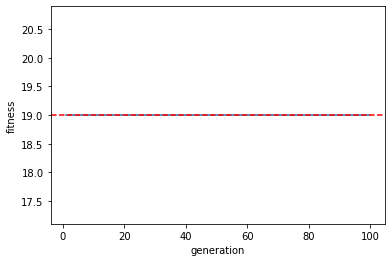

In [3]:
PROBLEM_INSTANCE_NAME = 'FIVE'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=20, max_generations=100)
ga.run()
stats_df = ga.fitness_df()
optimal_fitness = tsp_fitness(problem_instance, best_solution)
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.show()

Generation: 100%|██████████| 100/100 [00:02<00:00, 38.31it/s]


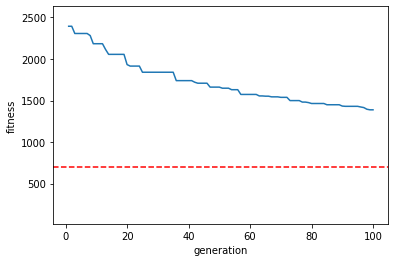

In [6]:
PROBLEM_INSTANCE_NAME = 'DANTZIG42'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=100, max_generations=100)
np.random.seed(123)
ga.run()
stats_df = ga.fitness_df()
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(699, color='red', linestyle='--')
plt.show()

Generation: 100%|██████████| 100/100 [00:02<00:00, 37.61it/s]


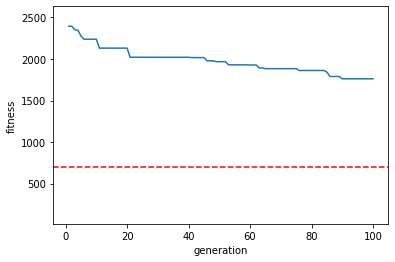

In [7]:
PROBLEM_INSTANCE_NAME = 'DANTZIG42'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=100, max_generations=100)
np.random.seed(123)
ga.run()
stats_df = ga.fitness_df()
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(699, color='red', linestyle='--')
plt.show()

Generation: 100%|██████████| 100/100 [00:02<00:00, 35.31it/s]


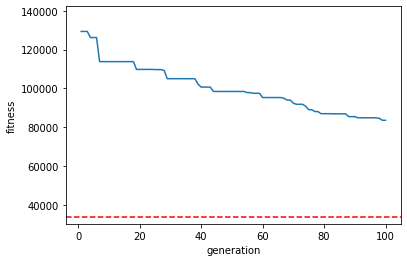

In [4]:
PROBLEM_INSTANCE_NAME = 'ATT48'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=100, max_generations=100, mutation_rate=0.1)
ga.run()
stats_df = ga.fitness_df()
optimal_fitness = tsp_fitness(problem_instance, best_solution)
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.show()

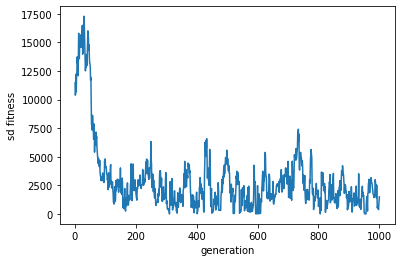

In [7]:
chart = sns.lineplot(data=stats_df, x='generation', y='sd fitness')
plt.show()

Generation: 100%|██████████| 1000/1000 [00:15<00:00, 66.43it/s]


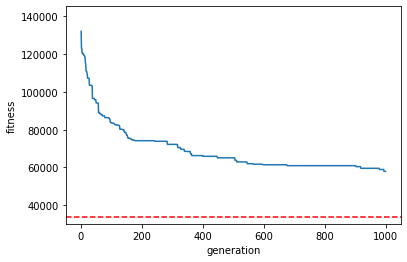

In [5]:
PROBLEM_INSTANCE_NAME = 'ATT48'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ga = GeneticAltorithmTSP(problem_instance, population_size=100, max_generations=1000)
ga.run()
stats_df = ga.fitness_df()
optimal_fitness = tsp_fitness(problem_instance, best_solution)
chart = sns.lineplot(data=stats_df, x='generation', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.show()

In [5]:
# Far from optimal solution
# solutions do not seem to vary much -> no change for 150 generations

# Possible Problems:
# higher mutation rate needed? 
#   -> perform some runs with varying mutation rate
# swapping just on gene in mutaten just to little?
#   -> swap muliple genes by parameter
# problem with crossover?
#   -> add assertions
# does corossover function make sense ? 
# to much elites ?

# TSP with Ant System

Time Point: 100%|██████████| 100/100 [00:00<00:00, 297.76it/s]


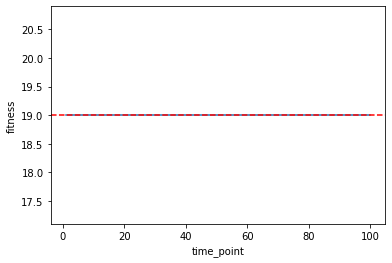

In [7]:
PROBLEM_INSTANCE_NAME = 'FIVE'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ant_system = AntSystem(AntTSP, problem_instance)
ant_system.run()
stats_df = ant_system.fitness_df()
optimal_fitness = tsp_fitness(problem_instance, best_solution)
chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.show()

Time Point: 100%|██████████| 100/100 [00:03<00:00, 25.22it/s]


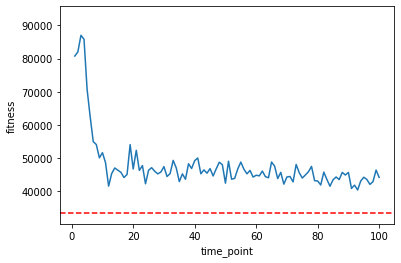

In [8]:
PROBLEM_INSTANCE_NAME = 'ATT48'

tsp_loader = TSPLoader(PROBLEM_INSTANCE_NAME)
problem_instance, best_solution = tsp_loader.load_problem_instance()
ant_system = AntSystem(AntTSP, problem_instance)
ant_system.run()
stats_df = ant_system.fitness_df()
optimal_fitness = tsp_fitness(problem_instance, best_solution)
chart = sns.lineplot(data=stats_df, x='time_point', y='fitness')
plt.ylim(optimal_fitness * 0.9, stats_df.fitness.max() * 1.1)
chart.axhline(optimal_fitness, color='red', linestyle='--')
plt.show()